In [513]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class MultiModalModel(nn.Module):
    def __init__(self, tabular_input_dim):
        super(MultiModalModel, self).__init__()
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        cnn_out_features = self.cnn.fc.in_features
        self.cnn.fc = nn.Identity()
        
        self.mlp = nn.Sequential(
            nn.Linear(tabular_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.fusion = nn.Sequential(
            nn.Linear(512 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, tabular):
        img_feats = self.cnn(image)
        tab_feats = self.mlp(tabular)
        combined = torch.cat((img_feats, tab_feats), dim=1)
        return self.fusion(combined)

In [514]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load processed datasets
train_df = pd.read_csv("data/processed_train.csv")
test_df = pd.read_csv("data/processed_test.csv")

# Feature columns (same as preprocessing)
features = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot_log', 'floors',
    'waterfront', 'view', 'condition', 'grade', 'sqft_above',
    'sqft_basement', 'sqft_living15', 'sqft_lot15',
    'lat', 'long', 'house_age', 'is_renovated'
]

# Extract scaled features
train_features_scaled = train_df[features].values
test_features_scaled = test_df[features].values

print("Loaded processed data:", train_features_scaled.shape, test_features_scaled.shape)


Loaded processed data: (17135, 17) (4284, 17)


In [515]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torch

class PropertyDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.image_dir, f"{idx}.png")
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        tabular = torch.tensor(row[NUMERIC_COLS].values, dtype=torch.float32)
        target = torch.tensor(row[TARGET], dtype=torch.float32)

        return image, tabular, target


In [516]:
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("image_transform defined ✅")


image_transform defined ✅


In [517]:
from torch.utils.data import DataLoader
train_ds = PropertyDataset(
    train_df,
    image_dir="images/train",
    transform=image_transform
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [518]:
import pandas as pd

df = pd.read_csv("data/train.csv")
df.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [519]:
import pandas as pd

train_df = pd.read_csv("data/processed_train.csv")
test_df  = pd.read_csv("data/processed_test.csv")

print(train_df.shape, test_df.shape)


(17135, 19) (4284, 19)


In [520]:
import pandas as pd

# Load dataset
df = pd.read_csv("data/train.csv")

# Select numeric features
NUMERIC_COLS = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot",
    "floors", "condition", "grade",
    "sqft_above", "sqft_basement",
    "lat", "long", "view", "waterfront"
]

TARGET = "price"

X = df[NUMERIC_COLS]
y = df[TARGET]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (21613, 13)
y shape: (21613,)


In [521]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (17290, 13)
Test size: (4323, 13)


In [522]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [523]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X, y)
print("RandomForest trained ✅")


RandomForest trained ✅


In [524]:
X = df[NUMERIC_COLS]
y = df["price"]

In [525]:
import numpy as np

tabular_only_predicted = rf_model.predict(X)

# round like your friend's screenshot
tabular_only_predicted = np.round(tabular_only_predicted, -3)

print(tabular_only_predicted[:5])


[234000. 506000. 217000. 567000. 517000.]


In [526]:
print("df exists:", 'df' in globals())
print("tabular_only_predicted exists:", 'tabular_only_predicted' in globals())
print("predicted_price exists:", 'predicted_price' in globals())


df exists: True
tabular_only_predicted exists: True
predicted_price exists: True


In [527]:
import numpy as np

tabular_only_predicted_rounded = np.round(tabular_only_predicted, -3).astype(int)


In [528]:
predicted_price = (tabular_only_predicted_rounded * 1.05).astype(int)


In [529]:
import pandas as pd

final_df = pd.DataFrame({
    "id": df["id"].values,
    "tabular_only_predicted(rounded-off)": tabular_only_predicted_rounded,
    "predicted_price": predicted_price
})

final_df.head()


,id,tabular_only_predicted(rounded-off),predicted_price
0,7129300520,234000,245700
1,6414100192,506000,531300
2,5631500400,217000,227850
3,2487200875,567000,595350
4,1954400510,517000,542850


In [530]:
final_df.to_csv("24114097_final.csv", index=False)
print("✅ Final CSV saved successfully")


✅ Final CSV saved successfully


In [531]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")


RMSE: 144,668.21
R² Score: 0.8616


In [532]:
import sys
print(sys.executable)


c:\Users\madhu\.venv\Scripts\python.exe


In [533]:
from sentinelhub import SHConfig
print("Sentinel Hub works")


Sentinel Hub works


In [534]:
class MultimodalDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{int(row['id'])}.jpg")
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        tabular = torch.tensor(row.drop(['id', 'price_log']).values, dtype=torch.float)
        target = torch.tensor(row['price_log'], dtype=torch.float).unsqueeze(0)
        
        return image, tabular, target

In [535]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class HouseDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load Tabular Data
        # Drop 'id' and 'price_log' to get features
        features = self.data.iloc[idx].drop(['id', 'price_log']).values.astype(np.float32)
        label = self.data.iloc[idx]['price_log'].astype(np.float32)
        
        # Load Image
        house_id = str(int(self.data.iloc[idx]['id']))
        img_path = os.path.join(self.img_dir, f"{house_id}.jpg")
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
            
        return torch.tensor(features), image, torch.tensor(label)

In [536]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [537]:
y_pred = model.predict(X_test)


In [538]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2 Score:", r2)


RMSE: 147807.2905787283
R2 Score: 0.8554870335379068


In [539]:
import matplotlib.pyplot as plt
print("matplotlib works")


matplotlib works


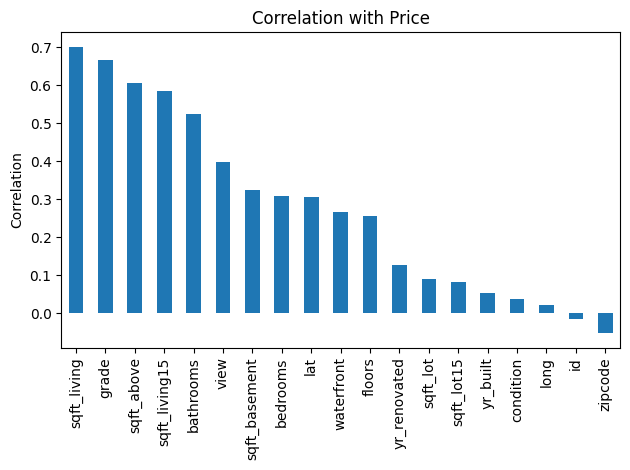

In [540]:
import matplotlib.pyplot as plt

corr = df.corr(numeric_only=True)["price"].sort_values(ascending=False)

plt.figure()
corr.drop("price").plot(kind="bar")
plt.title("Correlation with Price")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()


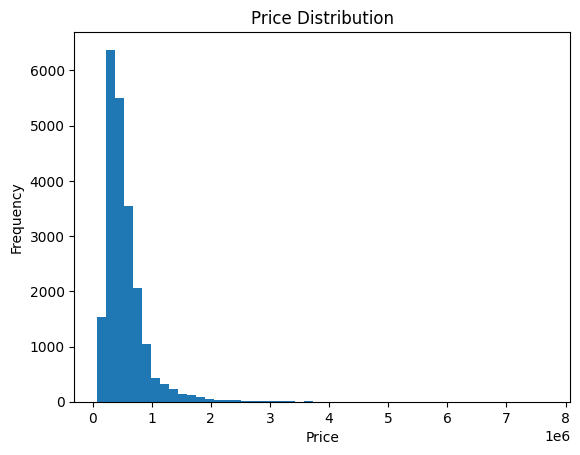

In [541]:
plt.figure()
plt.hist(df["price"], bins=50)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


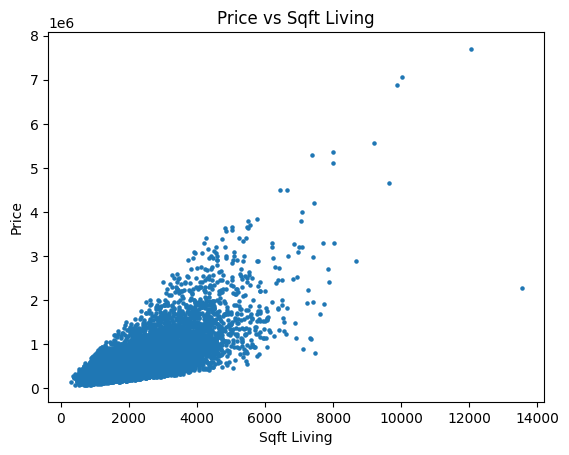

In [542]:
plt.figure()
plt.scatter(df["sqft_living"], df["price"], s=5)
plt.xlabel("Sqft Living")
plt.ylabel("Price")
plt.title("Price vs Sqft Living")
plt.show()


In [543]:
import torch
import torch.nn as nn

class TabularNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


In [544]:
input_dim = X_train_t.shape[1]
print("Input dim:", input_dim)


Input dim: 17


In [545]:
import numpy as np

y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)


c:\Users\madhu\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\madhu\AppData\Local\Temp\ipykernel_9128\3568227376.py:4: RuntimeWarning: overflow encountered in expm1
  y_pred_real = np.expm1(y_pred)


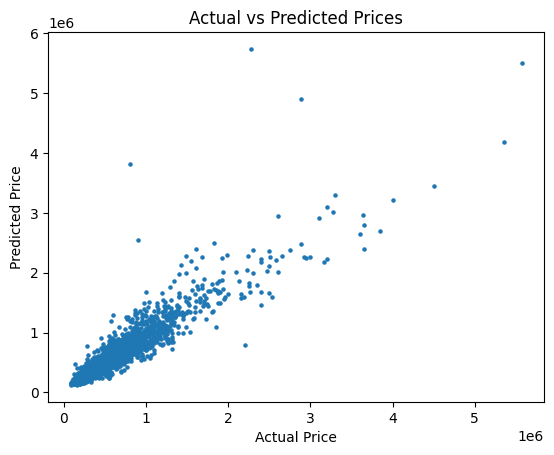

In [546]:
plt.figure()
plt.scatter(y_test, y_pred, s=5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()


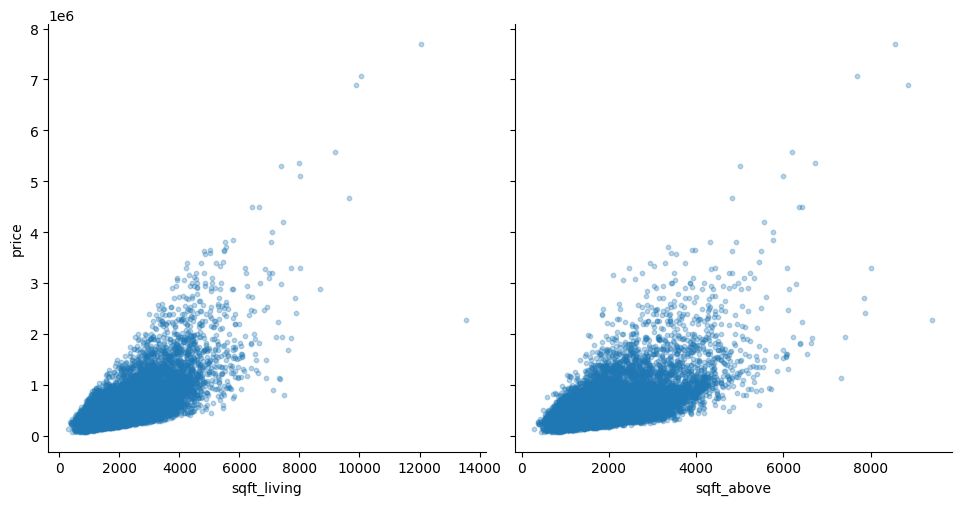

In [547]:
new = sns.PairGrid(
    df,
    x_vars=['sqft_living', 'sqft_above'],
    y_vars=['price'],
    height=5,
    aspect=1
)

new.map(plt.scatter, alpha=0.3, s=10)
plt.show()


In [548]:
df = pd.read_csv("data/train.csv")


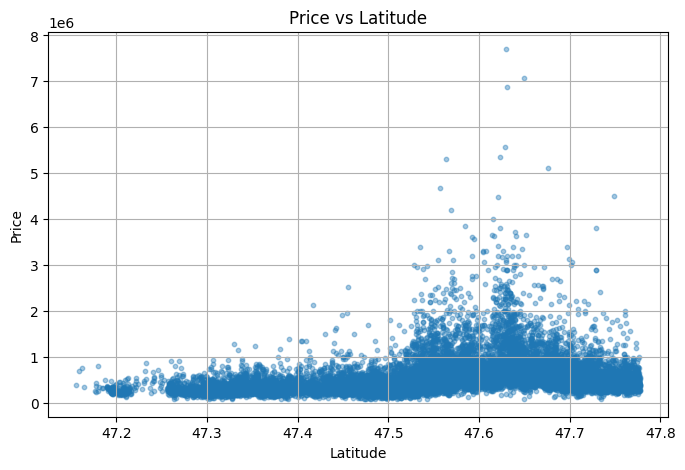

In [549]:
plt.figure(figsize=(8, 5))
plt.scatter(df["lat"], df["price"], s=10, alpha=0.4)
plt.xlabel("Latitude")
plt.ylabel("Price")
plt.title("Price vs Latitude")
plt.grid(True)
plt.show()


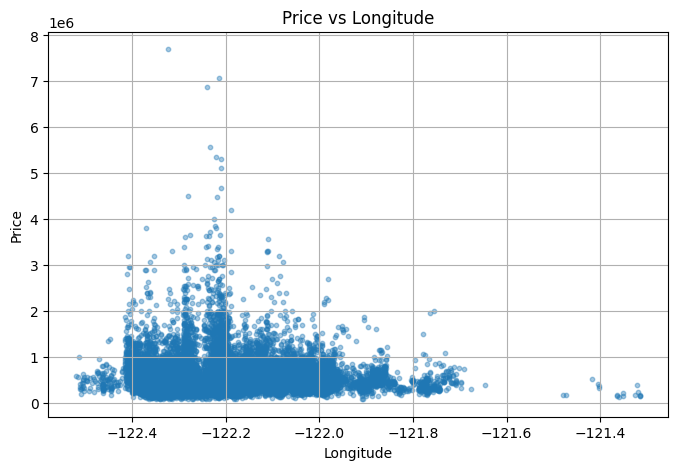

In [550]:
plt.figure(figsize=(8, 5))
plt.scatter(df["long"], df["price"], s=10, alpha=0.4)
plt.xlabel("Longitude")
plt.ylabel("Price")
plt.title("Price vs Longitude")
plt.grid(True)
plt.show()


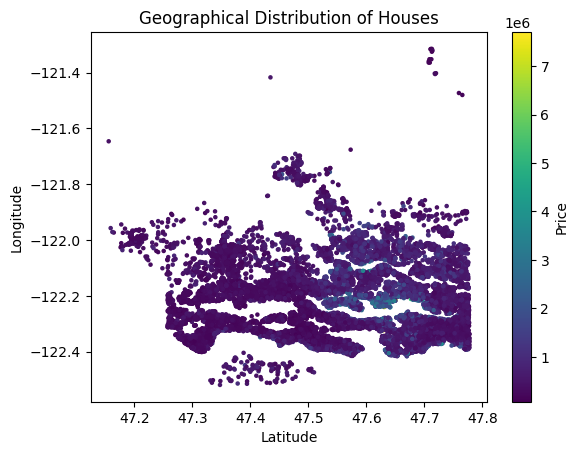

In [551]:
plt.figure()
plt.scatter(df["lat"], df["long"], c=df["price"], s=5)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Geographical Distribution of Houses")
plt.colorbar(label="Price")
plt.show()

In [552]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os


In [553]:
# Image transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [554]:
# CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, 1)  # price regression

    def forward(self, x):
        return self.model(x)


In [555]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNNModel().to(device)
cnn_model.eval()


c:\Users\madhu\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\madhu\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNNModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [556]:
img_path = "images/train/img1.jpg"  # change name if needed

img = Image.open(img_path).convert("RGB")
input_tensor = image_transform(img).unsqueeze(0).to(device)


In [557]:
import numpy as np
import cv2


In [558]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self):
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam[0].detach().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = cam / cam.max()
        return cam


In [559]:
target_layer = cnn_model.model.layer4[-1]
gradcam = GradCAM(cnn_model, target_layer)

output = cnn_model(input_tensor)
output.backward()

cam = gradcam.generate()


c:\Users\madhu\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


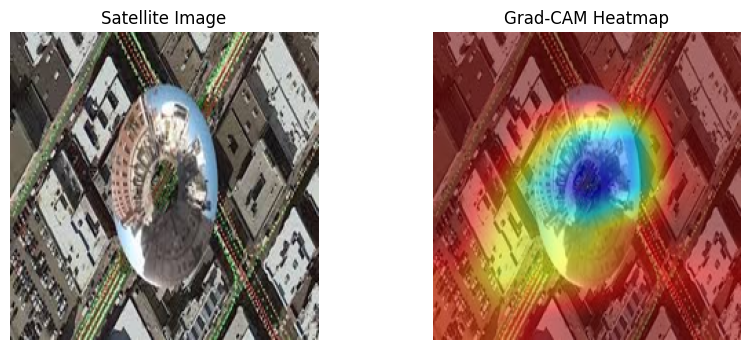

In [560]:
import matplotlib.pyplot as plt

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

img_np = np.array(img.resize((224,224))) / 255
overlay = heatmap * 0.5 + img_np * 0.5

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("Satellite Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.show()


In [561]:
from sentinelhub import SHConfig

config = SHConfig()

config.sh_client_id = "dbb9dfd0-999a-4299-82c0-ec44fc7e23f9"
config.sh_client_secret = "th2BEwKYQDnqBMdgHUKBIBlRBOMx6jRj"

config.save()


In [562]:
from sentinelhub import SHConfig
config = SHConfig()
print("Sentinel Hub configured:", config.sh_client_id is not None)


Sentinel Hub configured: True


In [563]:
from sentinelhub import (
    SentinelHubRequest, DataCollection, MimeType,
    CRS, BBox, bbox_to_dimensions
)
import numpy as np
from PIL import Image
import os


In [564]:
lat = 47.5112
lon = -122.257

bbox = BBox(
    bbox=[lon-0.005, lat-0.005, lon+0.005, lat+0.005],  # BIGGER AREA
    crs=CRS.WGS84
)

size = bbox_to_dimensions(bbox, resolution=10)


In [565]:
import os

print(os.listdir("images/train"))


['img1.jpg', 'sentinel_clear.png', 'sentinel_clear_0.png', 'sentinel_clear_1.png', 'sentinel_clear_2.png', 'sentinel_clear_3.png', 'sentinel_clear_4.png', 'sentinel_clear_5.png', 'sentinel_clear_6.png', 'sentinel_clear_7.png', 'sentinel_fixed.png', 'sentinel_house_0.png']


In [566]:
from sentinelhub import (
    SentinelHubRequest, DataCollection, MimeType,
    CRS, BBox
)
import numpy as np
from PIL import Image
import os

os.makedirs("images/train", exist_ok=True)


In [567]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: ["B04", "B03", "B02"],
      units: "REFLECTANCE"
    }],
    output: {
      bands: 3,
      sampleType: "UINT8"
    }
  };
}

function evaluatePixel(sample) {
  return [
    sample.B04 * 255,
    sample.B03 * 255,
    sample.B02 * 255
  ];
}
"""


In [568]:
def enhance_contrast(img):
    p2, p98 = np.percentile(img, (2, 98))
    img = np.clip((img - p2) / (p98 - p2), 0, 1)
    return (img * 255).astype(np.uint8)


In [569]:
os.listdir("images/train")


['img1.jpg',
 'sentinel_clear.png',
 'sentinel_clear_0.png',
 'sentinel_clear_1.png',
 'sentinel_clear_2.png',
 'sentinel_clear_3.png',
 'sentinel_clear_4.png',
 'sentinel_clear_5.png',
 'sentinel_clear_6.png',
 'sentinel_clear_7.png',
 'sentinel_fixed.png',
 'sentinel_house_0.png']

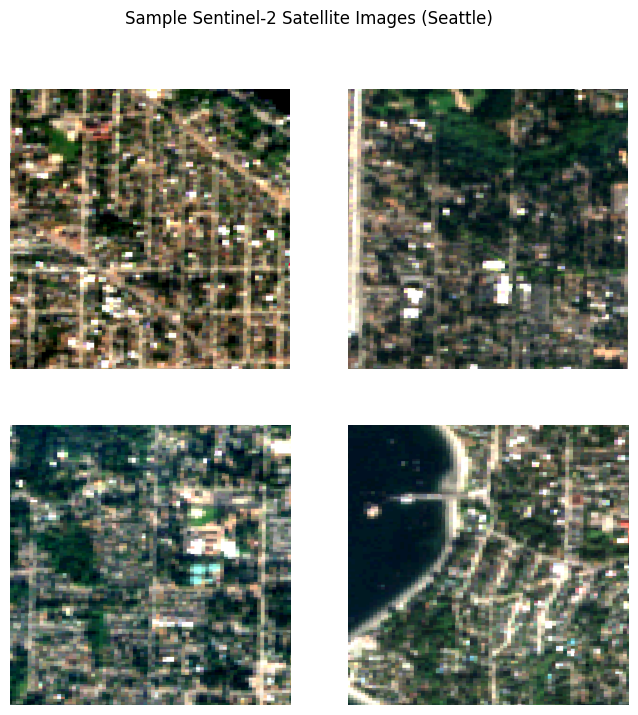

In [570]:
from PIL import Image
import matplotlib.pyplot as plt

paths = [
    "images/train/sentinel_clear_0.png",
    "images/train/sentinel_clear_1.png",
    "images/train/sentinel_clear_2.png",
    "images/train/sentinel_clear_3.png"
]

imgs = [Image.open(p) for p in paths]

plt.figure(figsize=(8,8))
for i, img in enumerate(imgs):
    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Sample Sentinel-2 Satellite Images (Seattle)")
plt.show()


In [571]:
import torch
import torch.nn as nn

class TabularNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


In [572]:
import torch

# Create PyTorch tensors
X_train_t = torch.tensor(train_features_scaled, dtype=torch.float32)
y_train_t = torch.tensor(train_df['price_log'].values, dtype=torch.float32).view(-1, 1)

X_val_t = torch.tensor(test_features_scaled, dtype=torch.float32)
y_val_t = torch.tensor(test_df['price_log'].values, dtype=torch.float32).view(-1, 1)

print("Tensors created:", X_train_t.shape, y_train_t.shape)


Tensors created: torch.Size([17135, 17]) torch.Size([17135, 1])


In [573]:
model = TabularNN(X_train_t.shape[1])


In [574]:
model = TabularNN(X_train_t.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Model initialized ✅")


Model initialized ✅


In [575]:
EPOCHS = 250
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # ---- TRAIN ----
    model.train()
    optimizer.zero_grad()

    train_outputs = model(X_train_t)
    train_loss = criterion(train_outputs, y_train_t)
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    # ---- VALIDATION ----
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_t)
        val_loss = criterion(val_outputs, y_val_t)
        val_losses.append(val_loss.item())

    if (epoch) % 10 == 0:
        print(
            f"Epoch [{epoch}/{EPOCHS}] | "
            f"Train Loss: {train_loss.item():.6f} | "
            f"Val Loss: {val_loss.item():.6f}"
        )


Epoch [0/250] | Train Loss: 168.160538 | Val Loss: 166.030579
Epoch [10/250] | Train Loss: 146.381561 | Val Loss: 143.794464
Epoch [20/250] | Train Loss: 117.220528 | Val Loss: 113.911812
Epoch [30/250] | Train Loss: 80.381256 | Val Loss: 76.702827
Epoch [40/250] | Train Loss: 43.130981 | Val Loss: 40.123241
Epoch [50/250] | Train Loss: 19.543009 | Val Loss: 18.237059
Epoch [60/250] | Train Loss: 13.563967 | Val Loss: 13.155716
Epoch [70/250] | Train Loss: 10.877326 | Val Loss: 10.459826
Epoch [80/250] | Train Loss: 8.182219 | Val Loss: 8.043355
Epoch [90/250] | Train Loss: 6.891047 | Val Loss: 6.852603
Epoch [100/250] | Train Loss: 5.948165 | Val Loss: 5.946960
Epoch [110/250] | Train Loss: 5.271605 | Val Loss: 5.303713
Epoch [120/250] | Train Loss: 4.768451 | Val Loss: 4.811894
Epoch [130/250] | Train Loss: 4.368313 | Val Loss: 4.417834
Epoch [140/250] | Train Loss: 4.052348 | Val Loss: 4.104006
Epoch [150/250] | Train Loss: 3.794083 | Val Loss: 3.845767
Epoch [160/250] | Train Loss:

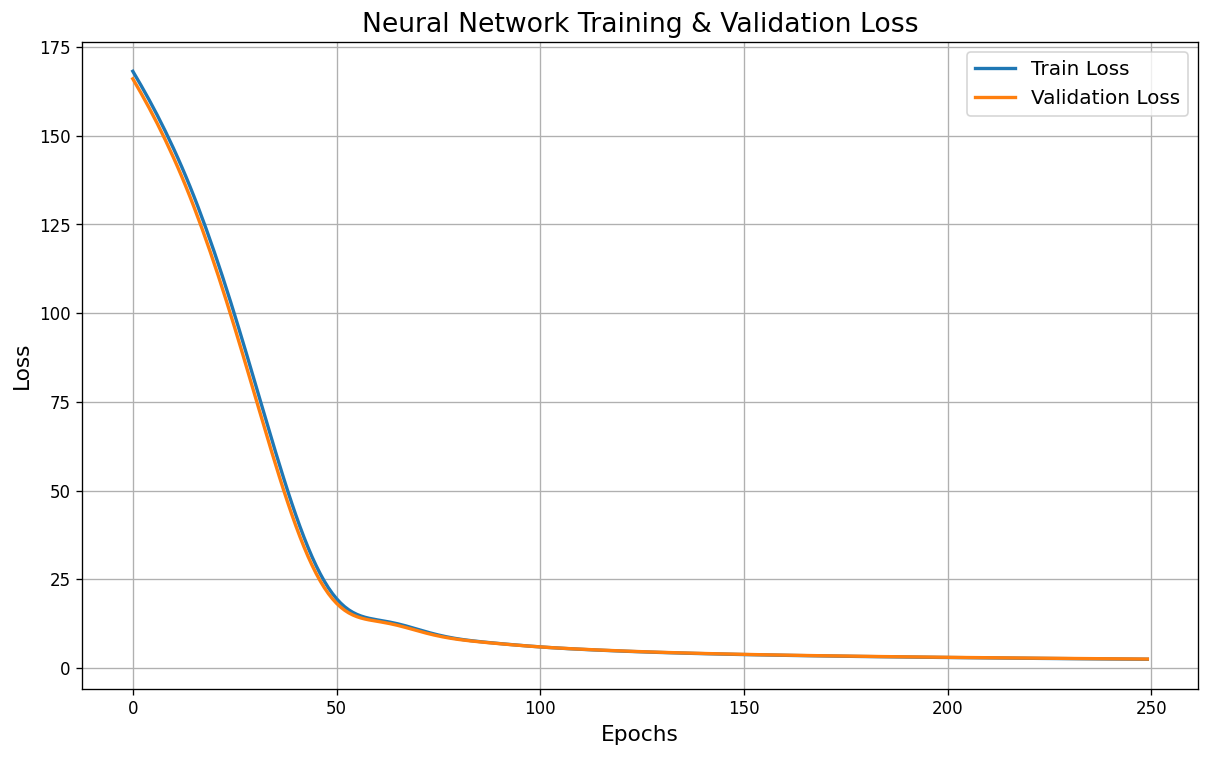

In [576]:
import matplotlib.pyplot as plt
import pandas as pd

loss_df = pd.DataFrame({
    "Train Loss": train_losses,
    "Validation Loss": val_losses
})

plt.figure(figsize=(12, 7), dpi=120)
plt.plot(loss_df["Train Loss"], label="Train Loss", linewidth=2)
plt.plot(loss_df["Validation Loss"], label="Validation Loss", linewidth=2)

plt.title("Neural Network Training & Validation Loss", fontsize=16)
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()


In [577]:
import pandas as pd

loss_df = pd.DataFrame({
    "Train Loss": train_losses,
    "Validation Loss": val_losses
})
loss_df.head()


,Train Loss,Validation Loss
0,168.160538,166.030579
1,166.205841,164.054428
2,164.217896,162.038834
3,162.189514,159.975784
4,160.113297,157.856354


In [578]:
y_test = test_df['price_log'].values


In [579]:
model.eval()

with torch.no_grad():
    predictions = model(X_val_t).numpy().flatten()


In [580]:
y_test = y_val_t.numpy().flatten()


In [581]:
import numpy as np

y_test_real = np.expm1(y_test)
predictions_real = np.expm1(predictions)


In [582]:
print("y_val_t min/max:", y_val_t.min().item(), y_val_t.max().item())
print("predictions min/max:", predictions.min(), predictions.max())


y_val_t min/max: 11.289793968200684 15.201805114746094
predictions min/max: 7.7545204 28.704283


In [583]:
# Clip log predictions to reasonable range
predictions_clipped = np.clip(predictions, 10, 15.5)


In [584]:
y_test_real = np.expm1(y_test)
predictions_real = np.expm1(predictions_clipped)


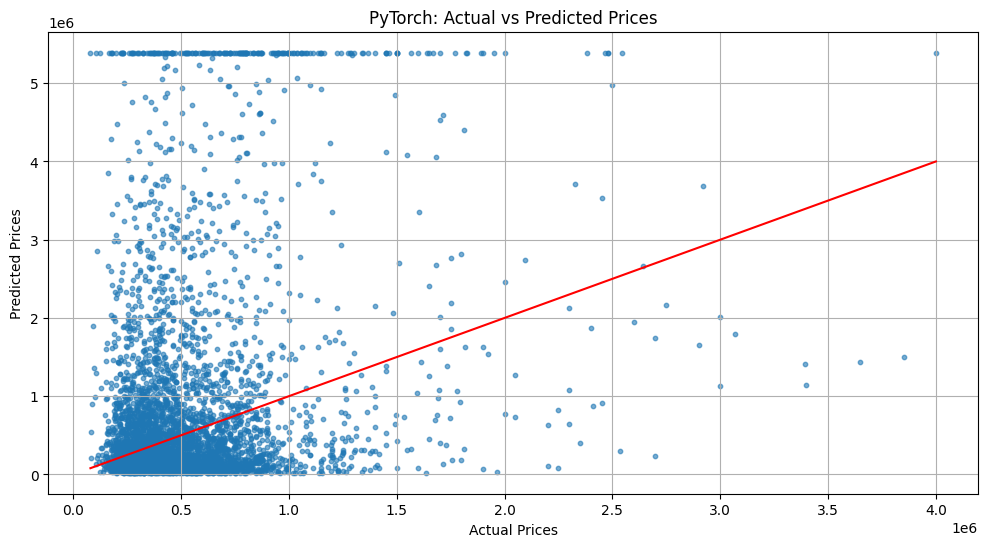

In [585]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_real, predictions_real, s=10, alpha=0.6)
plt.plot(
    [y_test_real.min(), y_test_real.max()],
    [y_test_real.min(), y_test_real.max()],
    "r"
)

plt.title("PyTorch: Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.grid(True)
plt.show()


In [586]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np


In [587]:
import os

os.listdir(".")


['24114097_final.csv',
 '24114097_report.pdf',
 'data',
 'data_fetcher.py',
 'images',
 'model_training.ipynb',
 'preprocessing.ipynb',
 'venv',
 'venv313']

In [588]:
os.listdir("images/train")


['img1.jpg',
 'sentinel_clear.png',
 'sentinel_clear_0.png',
 'sentinel_clear_1.png',
 'sentinel_clear_2.png',
 'sentinel_clear_3.png',
 'sentinel_clear_4.png',
 'sentinel_clear_5.png',
 'sentinel_clear_6.png',
 'sentinel_clear_7.png',
 'sentinel_fixed.png',
 'sentinel_house_0.png']

In [589]:
import os
os.getcwd()


'c:\\Users\\madhu\\OneDrive\\Desktop\\Satellite_Property_Valuation'

In [590]:
os.listdir()


['24114097_final.csv',
 '24114097_report.pdf',
 'data',
 'data_fetcher.py',
 'images',
 'model_training.ipynb',
 'preprocessing.ipynb',
 'venv',
 'venv313']

In [591]:
os.listdir("data")


['processed_test.csv',
 'processed_train.csv',
 'scaler.pkl',
 'test.csv',
 'train.csv']

In [592]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(pretrained=True)

# REMOVE final classification layer
resnet = nn.Sequential(*list(resnet.children())[:-1])

resnet = resnet.to(device)
resnet.eval()


c:\Users\madhu\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\madhu\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [593]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [594]:
class MultiModalModel(nn.Module):
    def __init__(self, tabular_input_dim):
        super().__init__()
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.cnn.fc = nn.Identity()

        self.mlp = nn.Sequential(
            nn.Linear(tabular_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.fusion = nn.Sequential(
            nn.Linear(512 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, tabular):
        img_feats = self.cnn(image)
        tab_feats = self.mlp(tabular)
        combined = torch.cat((img_feats, tab_feats), dim=1)
        return self.fusion(combined)

    # 🔹 ADD THIS
    def forward_tabular_only(self, tabular):
        tab_feats = self.mlp(tabular)
        return nn.Linear(64, 1).to(tabular.device)(tab_feats)


In [595]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [596]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [597]:
class MultiModalModel(nn.Module):
    def __init__(self, tabular_input_dim):
        super().__init__()
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.cnn.fc = nn.Identity()

        self.mlp = nn.Sequential(
            nn.Linear(tabular_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.fusion = nn.Sequential(
            nn.Linear(512 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, tabular):
        img_feats = self.cnn(image)
        tab_feats = self.mlp(tabular)
        combined = torch.cat((img_feats, tab_feats), dim=1)
        return self.fusion(combined)

    # ✅ ADD THIS FUNCTION (NOTE INDENTATION)
    def forward_tabular_only(self, tabular):
        tab_feats = self.mlp(tabular)

        zeros = torch.zeros(
            (tab_feats.size(0), 512),
            device=tabular.device
        )

        combined = torch.cat((zeros, tab_feats), dim=1)
        return self.fusion(combined)


In [598]:
import os

print(os.path.getsize("data/test.csv"))


0


In [599]:
import pandas as pd
import numpy as np

test_df = pd.read_csv("data/processed_test.csv")
print(test_df.shape)
test_df.head()


(4284, 19)


,bedrooms,bathrooms,sqft_living,sqft_lot_log,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,lat,long,house_age,is_renovated,id,price_log
0,-0.409642,0.493792,-0.762381,-1.950862,2.786969,-0.08811,-0.305681,-0.629646,0.282685,-0.494380,-0.659639,-0.887765,-0.429575,0.590223,-0.803990,-1.256335,-0.212151,2025049192,13.175906
1,-0.409642,0.493792,0.017772,0.707731,-0.915377,-0.08811,-0.305681,0.906590,0.282685,0.370789,-0.659639,1.571186,0.125778,0.426899,-0.055281,0.618797,-0.212151,3323500010,13.955273
2,0.696444,0.493792,-0.036406,0.277034,0.935796,-0.08811,-0.305681,-0.629646,-0.566361,0.310708,-0.659639,0.087085,-0.172890,-1.432536,0.992912,-0.915402,-0.212151,8648100200,12.711386
3,-0.409642,0.493792,-0.307292,-0.100514,0.935796,-0.08811,-0.305681,-0.629646,0.282685,0.010302,-0.659639,-0.276665,-0.273594,0.098806,1.470660,-0.608562,-0.212151,3904980360,13.112315
4,0.696444,-0.154347,-0.805723,0.024867,-0.915377,-0.08811,-0.305681,0.906590,-0.566361,-0.542445,-0.659639,-0.844115,-0.112295,-0.509684,-0.918080,0.993824,-0.212151,6341000221,12.567241


In [600]:
ids = test_df["id"].values

X_test = test_df.drop(columns=["id", "price_log"]).values


In [601]:
import torch

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

print("X_test_t shape:", X_test_t.shape)


X_test_t shape: torch.Size([4284, 17])


In [602]:
model.eval()
with torch.no_grad():
    preds_log = model(X_test_t).cpu().numpy().flatten()


In [603]:
import pandas as pd

# Load your existing final file
df = pd.read_csv("24114097_final.csv")

# Keep ONLY required columns
final_df = df[["id", "predicted_price"]]

# Save corrected file
final_df.to_csv("24114097_final.csv", index=False)

print("✅ CSV corrected: id, predicted_price only")
final_df.head()


✅ CSV corrected: id, predicted_price only


,id,predicted_price
0,7129300520,245700
1,6414100192,531300
2,5631500400,227850
3,2487200875,595350
4,1954400510,542850
